In [1]:
import os 
os.chdir("/workspaces/p99-bluesky/tests/")

import asyncio
import subprocess, os
from bluesky.run_engine import RunEngine
from ophyd_async.core import DeviceCollector
from ophyd_async.epics.signal import epics_signal_r, epics_signal_rw
from ophyd_async.core.signal import observe_value, wait_for_value
from p99_bluesky.devices.p99.sample_stage import (
    FilterMotor,
    SampleAngleStage,
    p99StageSelections,
)
from p99_bluesky.plans.fast_scan import fast_scan_1d, fast_scan_grid
from p99_bluesky.plans.stxm import stxm_fast,get_velocity_and_step_size
from soft_motor import SoftThreeAxisStage
from bluesky.run_engine import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky.plans import count, scan 
from ophyd.sim import noisy_det as det
bec = BestEffortCallback()
RE = RunEngine({})
from databroker import Broker
db = Broker.named('temp')
RE.subscribe(db.insert)
with DeviceCollector(mock=False):
    mock_sampleAngleStage = SampleAngleStage(
        "p99-MO-TABLE-01:", name="mock_sampleAngleStage"
    )
    mock_filter_wheel = FilterMotor(
        "p99-MO-STAGE-02:MP:SELECT", name="mock_filter_wheel"
    )
    xyz_motor = SoftThreeAxisStage("p99-MO-STAGE-02:", name="xyz_motor")

CA.Client.Exception...............................................
    Context: "Channel: "p99-MO-STAGE-02:XHLM", Connecting to: host.containers.internal:5064, Ignored: 192.168.122.1:5064"
    Source File: modules/ca/src/client/cac.cpp line 1320
    Current Time: Tue Jul 09 2024 11:21:00.593309030
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "p99-MO-STAGE-02:XSTOP", Connecting to: host.containers.internal:5064, Ignored: 192.168.122.1:5064"
    Source File: modules/ca/src/client/cac.cpp line 1320
    Current Time: Tue Jul 09 2024 11:21:00.593319786
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "p99-MO-STAGE-02:Y.EGU", Connecting to: host.containers.internal:5064, Ignored: 192.168.122.1:5064"
    Source File: modules/ca/src/client/cac.cpp line 1320
    Current Time: Tu

2024-07-09 11:21:30,504 - P99 - INFO - ideal step size = 0.2782926792421032 velocity = 1.391463396210516number of data point 249.978
2024-07-09 11:21:30,504 - P99 - INFO - xyz_motor-y velocity = 1.391463396210516.
2024-07-09 11:21:30,505 - P99 - INFO - xyz_motor-x step size = 0.2782926792421032.
2024-07-09 11:21:30,505 - P99 - INFO - xyz_motor-x number of step = 16.


Transient Scan ID: 2     Time: 2024-07-09 11:21:30
Persistent Unique Scan ID: 'b947e1a1-2cab-43db-9b8f-f6280d457912'
2024-07-09 11:21:30,507 - P99 - INFO - Check xyz_motor-x limits.
2024-07-09 11:21:30,508 - P99 - INFO - Check xyz_motor-y limits.
2024-07-09 11:21:30,512 - P99 - INFO - Moving xyz_motor-y to start position = -2.2.
2024-07-09 11:21:30,522 - P99 - INFO - Set xyz_motor-y speed = 1.391463396210516.
2024-07-09 11:21:30,522 - P99 - INFO - Set xyz_motor-y to end position(2.2) and begin scan.
New stream: 'primary'
+-----------+------------+-------------+------------+-------------+
|   seq_num |       time | xyz_mot

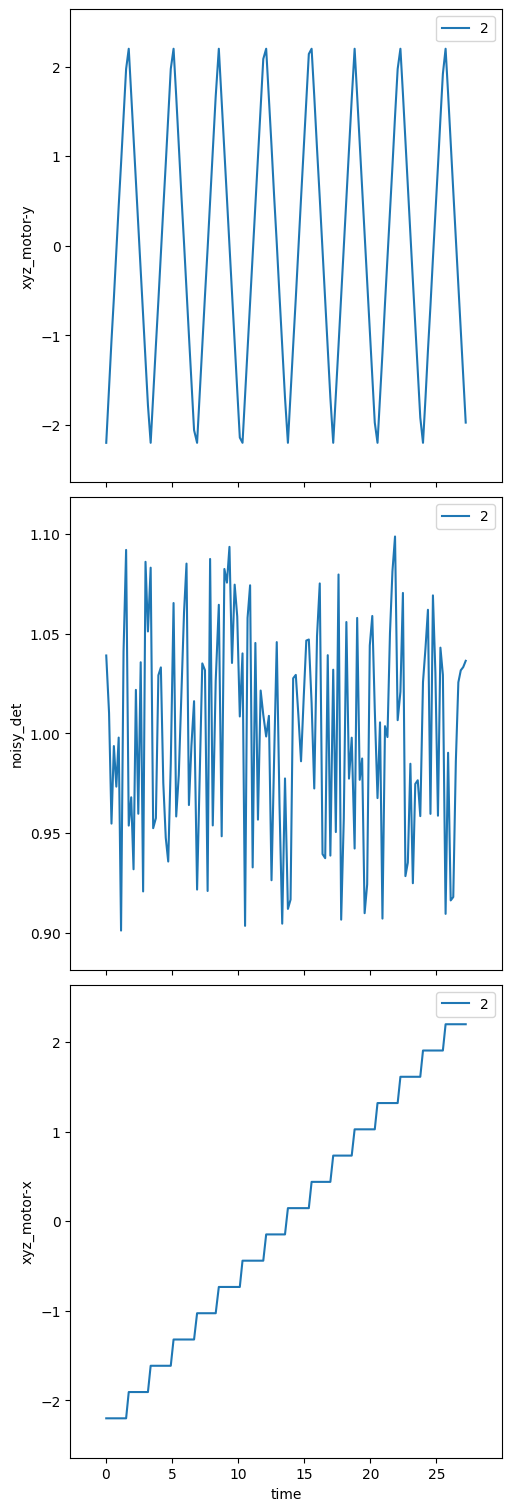

In [3]:
uid, = RE(stxm_fast(
    det=det,
    count_time = 0.2,
    step_motor = xyz_motor.x,
    step_start = -2.2,
    step_end   = 2.2,
    scan_motor = xyz_motor.y,
    scan_start = -2.2,
    scan_end   = 2.2,
    plan_time  = 50,
),bec)

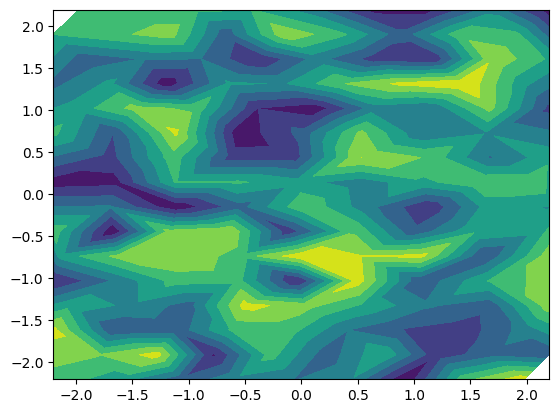

In [4]:
import matplotlib.pyplot as plt
header = db[-1]
data = header.table()
plt.tricontourf(data["xyz_motor-y"],data["xyz_motor-x"],data['noisy_det'])

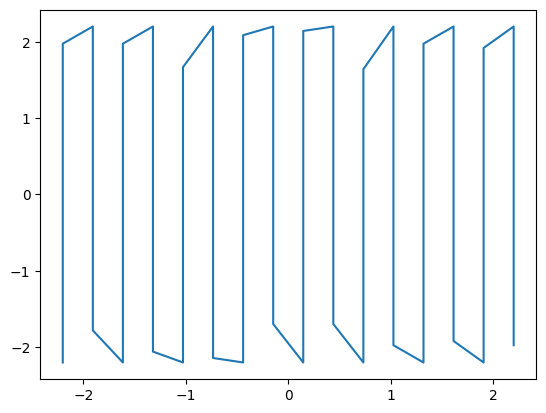

In [5]:
plt.plot(data["xyz_motor-x"],data["xyz_motor-y"])

2024-07-09 11:22:09,674 - P99 - INFO - ideal step size = 0.27829267924 velocity = 1.391463396221032number of data point 499.956
2024-07-09 11:22:09,675 - P99 - INFO - xyz_motor-y velocity = 1.391463396221032.
2024-07-09 11:22:09,675 - P99 - INFO - xyz_motor-x step size = 0.27829267924.
2024-07-09 11:22:09,675 - P99 - INFO - xyz_motor-x number of step = 16.


Transient Scan ID: 3     Time: 2024-07-09 11:22:09
Persistent Unique Scan ID: '745c6b97-9387-4c2b-9ec0-36b584095967'
2024-07-09 11:22:09,678 - P99 - INFO - Check xyz_motor-x limits.
2024-07-09 11:22:09,679 - P99 - INFO - Check xyz_motor-y limits.
2024-07-09 11:22:09,690 - P99 - INFO - Moving xyz_motor-y to start position = 2.2.
2024-07-09 11:22:09,699 - P99 - INFO - Set xyz_motor-y speed = 1.391463396221032.
2024-07-09 11:22:09,700 - P99 - INFO - Set xyz_motor-y to end position(-2.2) and begin scan.
New stream: 'primary'
+-----------+------------+-------------+------------+-------------+
|   seq_num |       time | xyz_motor-y |  no

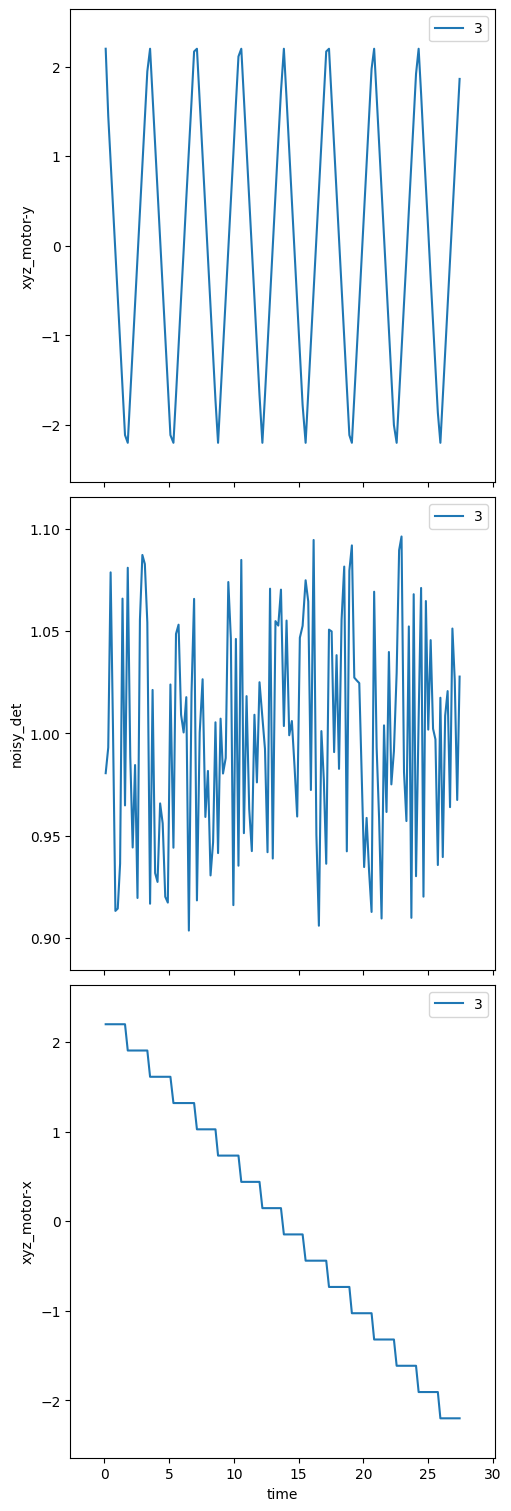

In [6]:
uid, = RE(stxm_fast(
    det=det,
    count_time = 0.1,
    step_motor = xyz_motor.x,
    step_start = 2.2,
    step_end   = -2.2,
    scan_motor = xyz_motor.y,
    scan_start = 2.2,
    scan_end   = -2.2,
    plan_time  = 50,
    step_size = -0.27829267924
),bec)

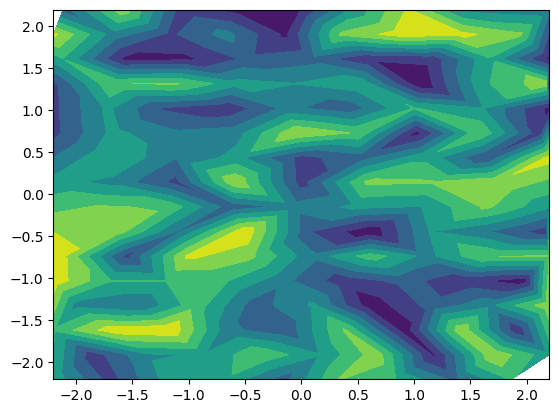

In [7]:
header = db[-1]
data = header.table()
plt.tricontourf(data["xyz_motor-y"],data["xyz_motor-x"],data['noisy_det'])


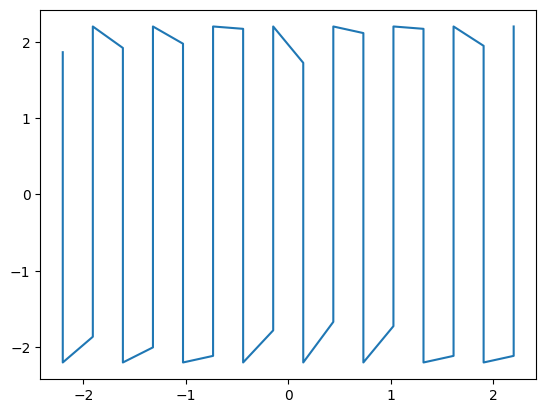

In [8]:
plt.plot(data["xyz_motor-x"],data["xyz_motor-y"])